This file will show you some examples of data exploration with scatterplots. At the end you will also find an example of a heatmap made with folium. The data that is used is a dataset from the Amsterdam municipality of solar panel installations in the last five years. You can find it here: https://maps.amsterdam.nl/open_geodata/ under the header 'Duurzaamheid'. It is geospatial data with in a [json file](https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=ZONNEPANELEN&THEMA=zonnepanelen) with attributes of wattage and amount of panels installed at a certain location. It makes sense that these two variables are correlated, but lets find out how much. We will start by plotting these two variables against each other in a scatterplot.

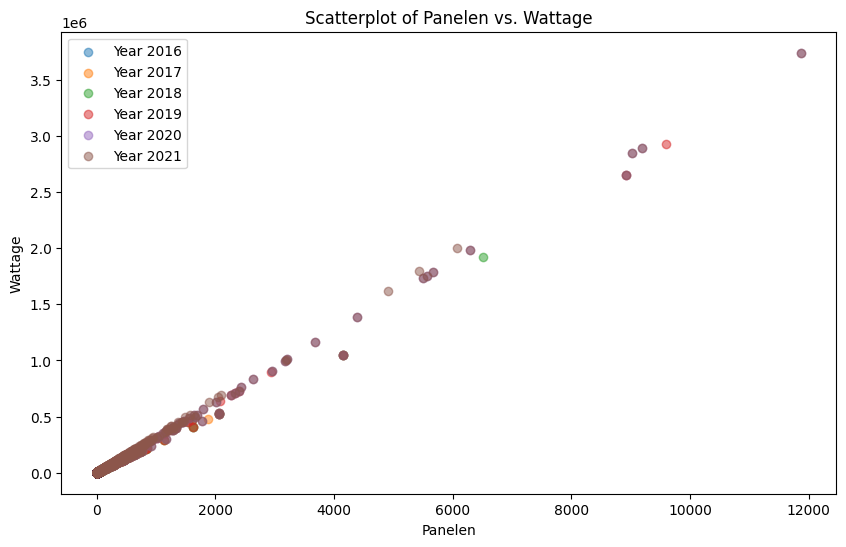

In [1]:
import requests
import matplotlib.pyplot as plt

# Define the URL to fetch the GeoJSON data
url = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=ZONNEPANELEN&THEMA=zonnepanelen"

# Fetch the GeoJSON data
response = requests.get(url)
data = response.json()

# Create a new figure
plt.figure(figsize=(10, 6))

# Extract Panelen and Wattage for each year from the GeoJSON features
years = ['2016', '2017', '2018', '2019', '2020', '2021']
for year in years:
    Panelen = [feature['properties']['Panelen_' + year] for feature in data['features']]
    Wattage = [feature['properties']['Wattage_' + year] for feature in data['features']]

    # Create a scatter plot for each year
    plt.scatter(Panelen, Wattage, alpha=0.5, label=f'Year {year}')

# Add labels to the axes
plt.xlabel('Panelen')
plt.ylabel('Wattage')

# Add a legend
plt.legend()

# Show the plot
plt.title('Scatterplot of Panelen vs. Wattage')
plt.show()



As you can see we get a nice plot, but the data is not very interesting. The most recent year is on top and has the most data points. We also see that the data set has quite some outliers. Lets try to see if we can make some lines for the different years for better comparison. We will only display the points of 2021 to avoid further confusion and lets clip the locations that have more than 3000 panels installed to avoid outliers. We can change the code to look the following:

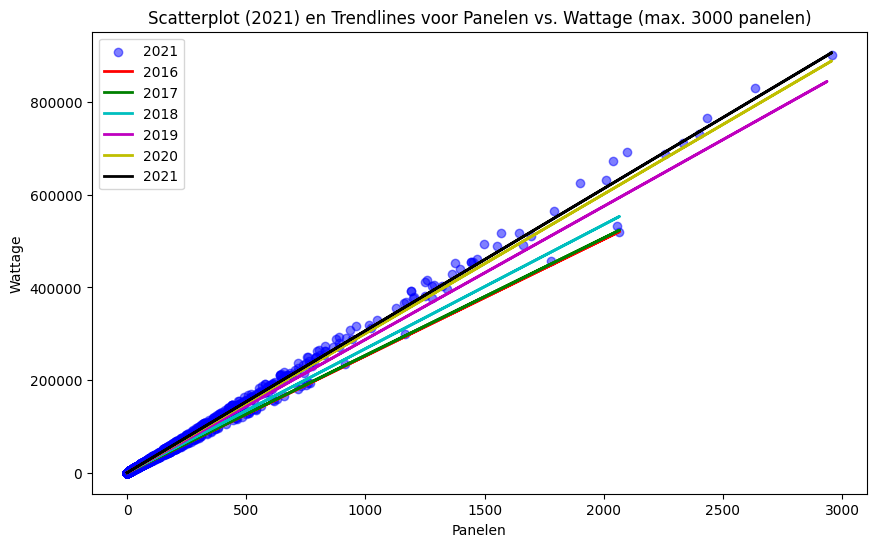

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Create a new figure
plt.figure(figsize=(10, 6))

# Extract Panelen and Wattage for 2021 from the GeoJSON features, only for points with <= 3000 panelen
Panelen_2021 = [feature['properties']['Panelen_2021'] for feature in data['features'] if feature['properties']['Panelen_2021'] <= 3000]
Wattage_2021 = [feature['properties']['Wattage_2021'] for feature in data['features'] if feature['properties']['Panelen_2021'] <= 3000]

# Scatter plot for 2021
plt.scatter(Panelen_2021, Wattage_2021, color='blue', alpha=0.5, label='2021')

# Extract Panelen and Wattage for all years from the GeoJSON features, only for points with <= 3000 panelen
years = ['2016', '2017', '2018', '2019', '2020', '2021']
colors = ['r', 'g', 'c', 'm', 'y', 'k']

for year, color in zip(years, colors):
    Panelen = [feature['properties']['Panelen_' + year] for feature in data['features'] if feature['properties']['Panelen_' + year] <= 3000]
    Wattage = [feature['properties']['Wattage_' + year] for feature in data['features'] if feature['properties']['Panelen_' + year] <= 3000]

    # Fit a linear regression model and plot the trendline
    X = np.array(Panelen).reshape(-1, 1)
    y = np.array(Wattage)
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    plt.plot(Panelen, y_pred, color=color, linestyle='-', linewidth=2, label=f'{year}')

# Add labels to the axes
plt.xlabel('Panelen')
plt.ylabel('Wattage')

# Add a legend
plt.legend()

# Show the plot
plt.title('Scatterplot (2021) en Trendlines voor Panelen vs. Wattage (max. 3000 panelen)')
plt.show()


Thats a nicer result! We can see that the trendline is moving in a gradual trend as solar panels become a bit more efficient every year. By getting rid of the points of all the years and making some lines, this trend becomes clear to still not extremely obvious.

Since we are working with spatial data, lets try for fun to plot the coordinates of the panels in a scatter plot as well.

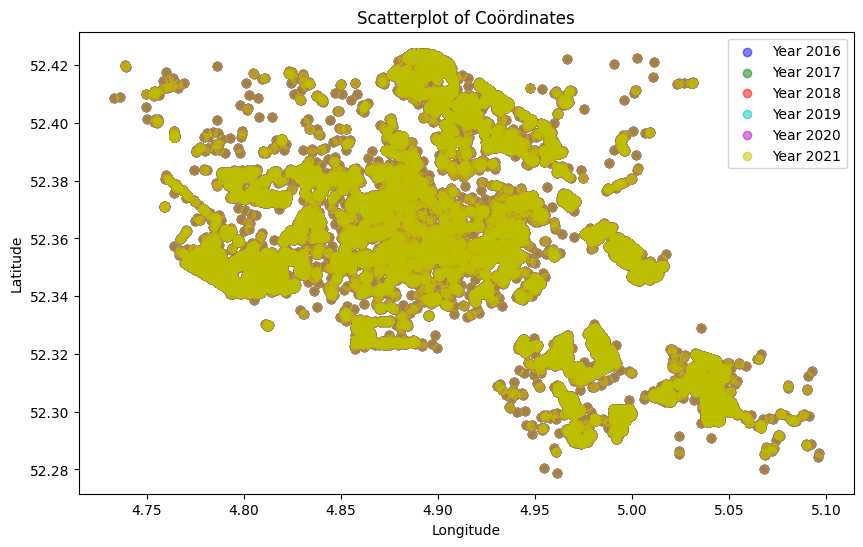

In [3]:
# Create a new figure
plt.figure(figsize=(10, 6))

# Extract latitude, longitude, and year from the GeoJSON features
years = ['2016', '2017', '2018', '2019', '2020', '2021']
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Different colors for different years
for i, year in enumerate(years):
    latitude = [feature['geometry']['coordinates'][1] for feature in data['features']]
    longitude = [feature['geometry']['coordinates'][0] for feature in data['features']]

    # Create a scatter plot for each year
    plt.scatter(longitude, latitude, color=colors[i], alpha=0.5, label=f'Year {year}')

# Add labels to the axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a legend
plt.legend()

# Show the plot
plt.title('Scatterplot of Coordinates')
plt.show()


That looks pretty terrible. We can see the outline of the city but once again the final year of data is dominant in the resulting plot. Another problem is that the point become so dense that you can not really see any hotspots. Also we usually like for maps to be a bit more interactive. Therefore lets try to make a heatmap with folium to solve these issues.

In [10]:
import folium
import requests
from folium.plugins import HeatMap
from IPython.display import display

# Initialize a map centered at Amsterdam
amsterdam_map = folium.Map(location=[52.3676, 4.9041], zoom_start=12)

# Extract the coordinates, wattage, and panelen for the year 2021
coordinates_2021 = []
wattage_2021 = []
panelen_2021 = []

for feature in data['features']:
    properties = feature['properties']
    if 'RADIUS_2021' in properties:
        lat, lon = feature['geometry']['coordinates'][1], feature['geometry']['coordinates'][0]
        wattage = properties.get('Wattage_2021', 0)
        panelen = properties.get('Panelen_2021', 0)

        coordinates_2021.append([lat, lon])
        wattage_2021.append(wattage)
        panelen_2021.append(panelen)

# Create a heatmap layer for Wattage in 2021
heatmap_layer_wattage_2021 = folium.FeatureGroup(name='Wattage 2021').add_to(amsterdam_map)
HeatMap(coordinates_2021, min_opacity=0.2, blur=23, name='Wattage 2021').add_to(heatmap_layer_wattage_2021)

# Create a heatmap layer for Panelen in 2021 with adjusted gradient
heatmap_layer_panelen_2021 = folium.FeatureGroup(name='Panelen 2021').add_to(amsterdam_map)
HeatMap(coordinates_2021, min_opacity=0.2, blur=23, name='Panelen 2021',
        gradient={0.2: 'blue', 0.4: 'cyan', 0.6: 'yellow', 0.8: 'orange', 1: 'red'}, overlay=True).add_to(heatmap_layer_panelen_2021)

# Add layer control for toggling layers
folium.LayerControl(collapsed=False).add_to(amsterdam_map)

# Display the map in the code viewer
display(amsterdam_map)

# Or save the map to an HTML file
amsterdam_map.save('solar_panel_heatmap_2021.html')
